### Relevante pakker

In [599]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm

Merk: ChatGPT har blitt brukt for å få hjelp til å skrive deler av denne koden.

### Rense dataene

In [600]:
df = pd.read_csv("Data/lego.population.csv", sep = ",", encoding = "latin1")
df

,Item_Number,Set_Name,Theme,Pieces,Price,Amazon_Price,Year,Ages,Pages,Minifigures,Packaging,Weight,Unique_Pieces,Availability,Size
0,41916,Extra Dots - Series 2,DOTS,109.0,$3.99,$3.44,2020,Ages_6+,NaN,NaN,Foil pack,NaN,6.0,Retail,Small
1,41908,Extra Dots - Series 1,DOTS,109.0,$3.99,$3.99,2020,Ages_6+,NaN,NaN,Foil pack,NaN,6.0,Retail,Small
2,11006,Creative Blue Bricks,Classic,52.0,$4.99,$4.93,2020,Ages_4+,37.0,NaN,Box,NaN,28.0,Retail,Small
3,11007,Creative Green Bricks,Classic,60.0,$4.99,$4.93,2020,Ages_4+,37.0,NaN,Box,NaN,36.0,Retail,Small
4,41901,Funky Animals Bracelet,DOTS,33.0,$4.99,$4.99,2020,Ages_6+,NaN,NaN,Foil pack,NaN,10.0,Retail,Small
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1299,45678,SPIKE Prime Set,LEGO® Education,528.0,$329.95,NaN,2020,Ages_10+,NaN,2.0,NaN,NaN,108.0,NaN,Small
1300,71367,Mario's House & Yoshi,LEGO® Super Mario,205.0,$29.99,NaN,2020,Ages_6+,NaN,2.0,Box,NaN,114.0,Retail,Small
1301,71368,Toad's Treasure Hunt,LEGO® Super Mario,464.0,$69.99,NaN,2020,Ages_8+,NaN,4.0,Box,NaN,195.0,Retail,Small
1302,71369,Bowser's Castle Boss Battle,LEGO® Super Mario,1010.0,$99.99,NaN,2020,Ages_8+,NaN,NaN,Box,NaN,346.0,Retail,Small


In [601]:
# fjerner forklaringsvariabler vi ikke trenger
df2 = df[['Set_Name', 'Theme', 'Pieces', 'Price', 'Pages', 'Minifigures', 'Unique_Pieces', 'Ages']]

# fjerner observasjoner med manglende datapunkter
df2 = df2.dropna()

# gjør themes om til string og fjern alle tegn vi ikke vil ha med
df2['Theme'] = df2['Theme'].astype(str)
df2['Theme'] = df2['Theme'].str.replace(r'[^a-zA-Z0-9\s-]', '', regex = True)

# fjerner dollartegn og trademark-tegn fra datasettet
df2['Price'] = df2['Price'].str.replace('\$', '', regex = True)

# og gjør så prisen om til float
df2['Price'] = df2['Price'].astype(float)

df2

,Set_Name,Theme,Pieces,Price,Pages,Minifigures,Unique_Pieces,Ages
13,Stephanie's Summer Heart Box,Friends,95.0,7.99,40.0,1.0,52.0,Ages_6+
16,Woody & RC,Disney,69.0,9.99,28.0,1.0,36.0,Ages_4+
17,Mia's Summer Heart Box,Friends,85.0,7.99,36.0,1.0,41.0,Ages_6+
18,Olivia's Summer Heart Box,Friends,93.0,7.99,40.0,2.0,48.0,Ages_6+
19,Police Patrol Car,City,92.0,9.99,36.0,1.0,52.0,Ages_5+
...,...,...,...,...,...,...,...,...
1171,1989 Batmobile,Batman,3306.0,249.99,404.0,3.0,484.0,Ages_16+
1172,Tree House,Ideas,3036.0,199.99,428.0,4.0,482.0,Ages_16+
1173,Welcome to Apocalypseburg!,THE LEGO MOVIE 2,3178.0,299.99,452.0,13.0,692.0,Ages_16+
1174,Jurassic Park: T. rex Rampage,Jurassic World,3120.0,249.99,464.0,6.0,525.0,Ages_16+


In [602]:
def categorize_age_from_theme(theme):
    if theme in ['DUPLO', 'Classic', 'Juniors']:
        return 'Småbarn'
    elif theme in ['Friends', 'City', 'Unikitty', 'NINJAGO', 'Minecraft', 'Batman', 'THE LEGO MOVIE 2', 'Speed Champions',
                   'Harry Potter', 'Hidden Side', 'LEGO Frozen 2', 'Trolls World Tour', 'Minions', 'Powerpuff Girls',
                   'Jurassic World', 'Overwatch', 'Spider-Man', 'Creator 3-in-1', 'Monkie Kid', 'Powered UP']:
        return 'Skolebarn'
    elif theme in ['Star Wars', 'Marvel', 'DC', 'Ideas', 'Creator Expert', 'Stranger Things']:
        return 'Eldre'
    elif theme in ['Disney', 'Minifigures']:
        return 'Uvisst'
    else:
        print("Unknown age group: " + theme)
        return 'Unknown'  # For aldersgrupper som ikke passer inn i de definerte kategoriene
    
def categorize_age_group(age_group):
    if age_group in ['Ages_1½+', 'Ages_2+', 'Ages_2-5']:
        return 'Småbarn'
    elif age_group in ['Ages_4+', 'Ages_5+', 'Ages_6+', 'Ages_4-7', 'Ages_5-10', 'Ages_6-10', 'Ages_5-99', 'Ages_7+', 'Ages_8+', 'Ages_7-12', 'Ages_8-12', 'Ages_7-14', 'Ages_8-14', 'Ages_5-12', 'Ages_6-12', 'Ages_6-14']:
        return 'Skolebarn'
    elif age_group in ['Ages_9+', 'Ages_10+', 'Ages_12+', 'Ages_9-14']:
        return 'Eldre_skolebarn'
    elif age_group in ['Ages_14+', 'Ages_16+', 'Ages_18+']:
        return 'Eldre'
    else:
        print("Unknown age group: " + age_group)
        return 'Unknown'  # For aldersgrupper som ikke passer inn i de definerte kategoriene

df2['Age_Category_Ages'] = df2['Ages'].apply(categorize_age_group)
df2['Age_Category'] = df2['Theme'].apply(categorize_age_from_theme)

### Mer eller mindre relevante kodesnutter

In [603]:
print(df2.mean(numeric_only = True))

Pieces           413.570028
Price             46.351345
Pages            103.260504
Minifigures        3.215686
Unique_Pieces    144.670868
dtype: float64


In [604]:
print(df2['Theme'].value_counts())
# print(df2['Age_Category'].value_counts())

Theme
Friends              94
City                 94
Star Wars            85
NINJAGO              77
Marvel               47
Disney               35
DUPLO                32
THE LEGO MOVIE 2     25
Harry Potter         22
Minecraft            21
Creator 3-in-1       21
Hidden Side          19
Jurassic World       19
Speed Champions      17
Batman               16
Juniors              12
Creator Expert       10
Monkie Kid            9
Ideas                 8
DC                    8
Trolls World Tour     8
Overwatch             7
LEGO Frozen 2         7
Unikitty              6
Classic               4
Minifigures           3
Spider-Man            2
Powerpuff Girls       2
Minions               2
Stranger Things       1
Powered UP            1
Name: count, dtype: int64


In [605]:
print(df2['Theme'].unique())

['Friends' 'Disney' 'City' 'Unikitty' 'NINJAGO' 'DUPLO' 'Star Wars'
 'Minecraft' 'Marvel' 'Batman' 'THE LEGO MOVIE 2' 'Speed Champions'
 'Harry Potter' 'Hidden Side' 'LEGO Frozen 2' 'Trolls World Tour'
 'Minions' 'Powerpuff Girls' 'Jurassic World' 'Overwatch' 'Classic'
 'Spider-Man' 'Juniors' 'Creator 3-in-1' 'DC' 'Ideas' 'Creator Expert'
 'Stranger Things' 'Monkie Kid' 'Minifigures' 'Powered UP']


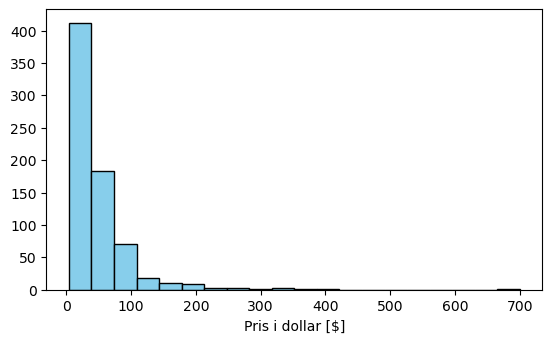

In [606]:
plt.hist(df2['Price'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Pris i dollar [$]')
plt.ylabel('')
plt.gca().set_aspect(1)
plt.show()

c:\Users\a_lun\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\a_lun\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


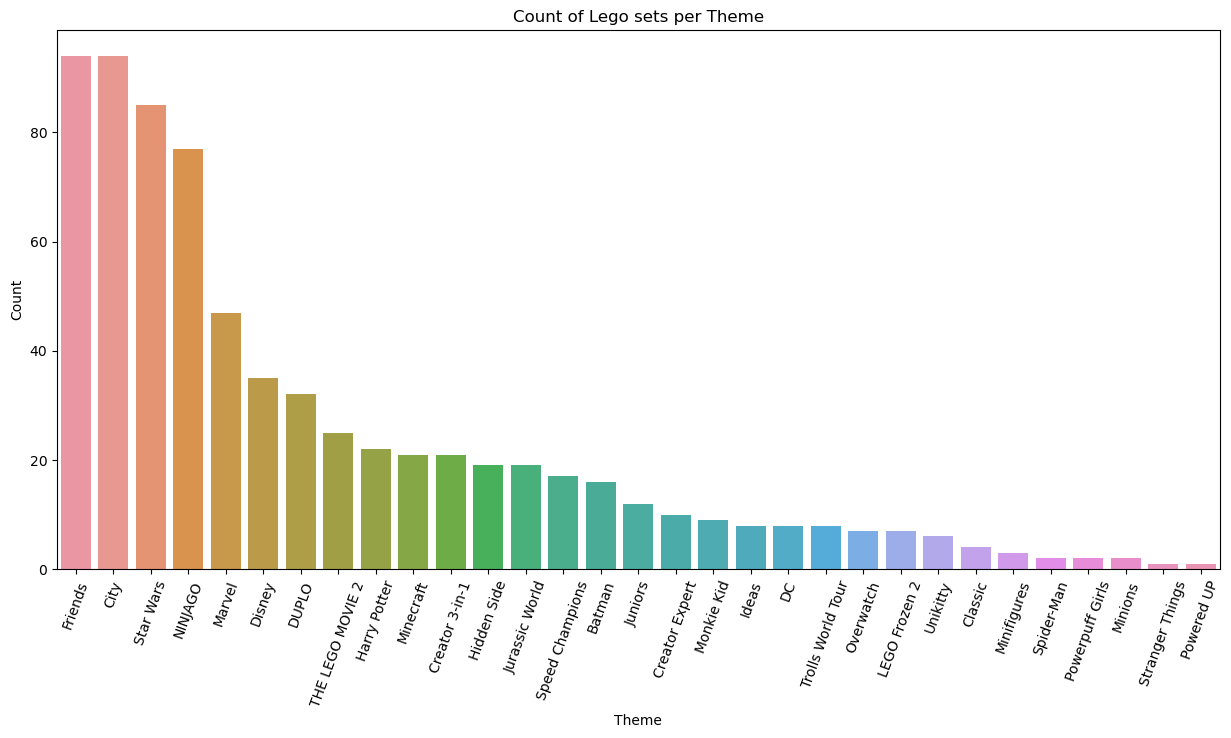

In [607]:
Theme_order = df2['Theme'].value_counts().index

# Set a larger figure size
plt.figure(figsize=(15, 7))

# Assuming df is your DataFrame with the 'Ages' column
sns.countplot(data=df2, x='Theme', order=Theme_order)

# Rotate x-axis labels for better readability
plt.xticks(rotation=70)  # You can adjust the angle as needed

# Make x-axis label box taller to fit the rotated labels
# plt.tight_layout()

# Adjust plot aesthetics if needed
plt.xlabel('Theme')
plt.ylabel('Count')
plt.title('Count of Lego sets per Theme')

# Show the plot
plt.show()

c:\Users\a_lun\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\a_lun\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


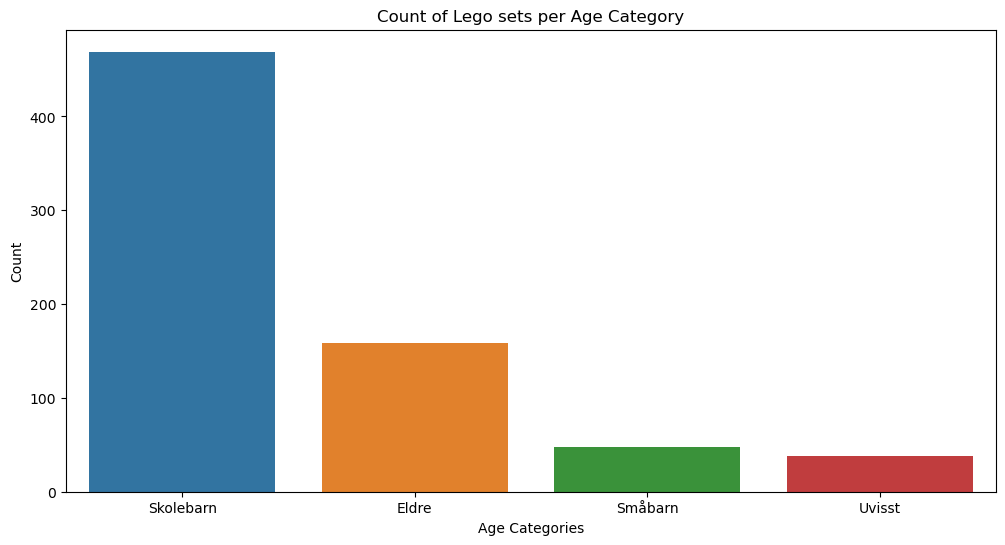

In [608]:
Age_Category_order = df2['Age_Category'].value_counts().index

# Set a larger figure size
plt.figure(figsize=(12, 6))

# Assuming df is your DataFrame with the 'Ages' column
sns.countplot(data=df2, x='Age_Category', order=Age_Category_order)

# Rotate x-axis labels for better readability
# plt.xticks(rotation=45)  # You can adjust the angle as needed

# Adjust plot aesthetics if needed
plt.xlabel('Age Categories')
plt.ylabel('Count')
plt.title('Count of Lego sets per Age Category')

# Show the plot
plt.show()

In [609]:
# Print all the Themes for each Age Category
for age_category in df2['Age_Category'].unique():
    print(age_category + ': ' + str(df2[df2['Age_Category'] == age_category]['Theme'].unique()))

Skolebarn: ['Friends' 'City' 'Unikitty' 'NINJAGO' 'Minecraft' 'Batman'
 'THE LEGO MOVIE 2' 'Speed Champions' 'Harry Potter' 'Hidden Side'
 'LEGO Frozen 2' 'Trolls World Tour' 'Minions' 'Powerpuff Girls'
 'Jurassic World' 'Overwatch' 'Spider-Man' 'Creator 3-in-1' 'Monkie Kid'
 'Powered UP']
Uvisst: ['Disney' 'Minifigures']
Småbarn: ['DUPLO' 'Classic' 'Juniors']
Eldre: ['Star Wars' 'Marvel' 'DC' 'Ideas' 'Creator Expert' 'Stranger Things']


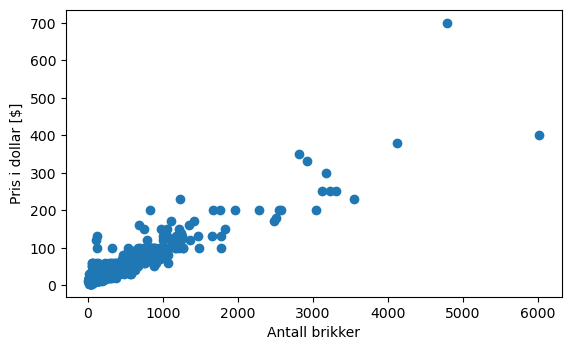

In [610]:
plt.scatter(df2['Pieces'], df2['Price'])
plt.xlabel('Antall brikker')
plt.ylabel('Pris i dollar [$]')
plt.gca().set_aspect(5)
plt.show()

In [611]:
# hva er det dyreste settet i datasettet mon tro?
print(df2.loc[df2['Price'].idxmax()])

Set_Name             Imperial Star Destroyer
Theme                              Star Wars
Pieces                                4784.0
Price                                 699.99
Pages                                  444.0
Minifigures                              2.0
Unique_Pieces                          445.0
Ages                                Ages_16+
Age_Category_Ages                      Eldre
Age_Category                           Eldre
Name: 825, dtype: object


In [612]:
# og hvilket har flest brikker?
print(df2.loc[df2['Pieces'].idxmax()])

Set_Name             Hogwarts Castle
Theme                   Harry Potter
Pieces                        6020.0
Price                         399.99
Pages                          636.0
Minifigures                     28.0
Unique_Pieces                  624.0
Ages                        Ages_16+
Age_Category_Ages              Eldre
Age_Category               Skolebarn
Name: 821, dtype: object


In [613]:
# hvilke tema har de billigste settene?
df2.groupby('Theme')['Price'].mean().sort_values(ascending=False)#[:3]

Theme
Powered UP           329.990000
Stranger Things      199.990000
Creator Expert       177.990000
Ideas                 96.865000
Monkie Kid            83.323333
Harry Potter          65.899091
Star Wars             62.213529
Jurassic World        62.095263
THE LEGO MOVIE 2      55.950000
DC                    52.490000
Spider-Man            49.990000
Creator 3-in-1        48.085238
Hidden Side           46.832105
Batman                46.552500
LEGO Frozen 2         45.704286
City                  44.670851
DUPLO                 39.052500
NINJAGO               38.509481
Marvel                38.500638
Overwatch             37.847143
Minecraft             36.180476
Minions               34.990000
Friends               30.117660
Classic               29.990000
Trolls World Tour     29.365000
Disney                28.075714
Speed Champions       27.637059
Powerpuff Girls       24.990000
Juniors               24.990000
Unikitty              18.990000
Minifigures           12.990000
Na

In [614]:
result = df2.groupby('Age_Category')['Ages'].value_counts().rename('count').reset_index()

filtered_result = result[result['count'] > 1].sort_values(by=['Age_Category', 'count'], ascending=[True, False])

print(filtered_result)

   Age_Category       Ages  count
0         Eldre    Ages_6+     23
1         Eldre    Ages_7+     22
2         Eldre    Ages_8+     20
3         Eldre  Ages_6-12     13
4         Eldre   Ages_16+     11
5         Eldre  Ages_8-14      9
6         Eldre    Ages_4+      9
7         Eldre    Ages_9+      8
8         Eldre  Ages_7-12      8
9         Eldre   Ages_10+      7
10        Eldre  Ages_9-14      6
11        Eldre  Ages_7-14      5
12        Eldre   Ages_12+      5
13        Eldre   Ages_14+      3
14        Eldre  Ages_5-12      3
15        Eldre   Ages_18+      3
20    Skolebarn    Ages_6+     83
21    Skolebarn    Ages_7+     75
22    Skolebarn    Ages_8+     65
23    Skolebarn    Ages_5+     47
24    Skolebarn  Ages_6-12     34
25    Skolebarn    Ages_9+     29
26    Skolebarn    Ages_4+     26
27    Skolebarn  Ages_5-12     24
28    Skolebarn  Ages_7-12     17
29    Skolebarn  Ages_8-14     13
30    Skolebarn  Ages_7-14     12
31    Skolebarn  Ages_6-14      9
32    Skolebar

In [615]:
# hvilke tema har flest brikker?
Age_Pieces = df2.groupby('Age_Category')['Pieces'].mean().sort_values(ascending=False)#[:5]

print('Average number of pieces per Age Category')
print()
print(Age_Pieces.reset_index().to_string(index=False, col_space=15))

Average number of pieces per Age Category

   Age_Category          Pieces
          Eldre      610.383648
      Skolebarn      400.558635
         Uvisst      136.842105
        Småbarn      107.833333


In [616]:
# Print the prices and Age_Category in a list with headers
Age_Price = df2.groupby('Age_Category')['Price'].mean().sort_values(ascending=False)

print('Average price per Age_Category:')
print()
print(Age_Price.reset_index().to_string(index=False, col_space=15))

Average price per Age_Category:

   Age_Category           Price
          Eldre       64.606352
      Skolebarn       42.923902
        Småbarn       34.781667
         Uvisst       26.884737


In [617]:
Age_UniquePieces = df2.groupby('Age_Category')['Unique_Pieces'].mean().sort_values(ascending=False)

print('Average number of unique pieces per Age_Category:')
print()
print(Age_UniquePieces.reset_index().to_string(index=False, col_space=15))

Average number of unique pieces per Age_Category:

   Age_Category   Unique_Pieces
          Eldre      169.641509
      Skolebarn      150.577825
         Uvisst       74.868421
        Småbarn       59.500000


In [618]:
Age_Minifigures = df2.groupby('Age_Category')['Minifigures'].mean().sort_values(ascending=False)

print('Average number of minifigures per Age_Category:')
print()
print(Age_Minifigures.reset_index().to_string(index=False, col_space=15))

Average number of minifigures per Age_Category:

   Age_Category     Minifigures
          Eldre        3.647799
      Skolebarn        3.240938
        Småbarn        2.312500
         Uvisst        2.236842


In [619]:
Age_Pages = df2.groupby('Age_Category')['Pages'].mean().sort_values(ascending=False)

print('Average number of pages per Age_Category:')
print()
print(Age_Pages.reset_index().to_string(index=False, col_space=15))

Average number of pages per Age_Category:

   Age_Category           Pages
      Skolebarn      112.040512
          Eldre      110.849057
         Uvisst       46.263158
        Småbarn       37.458333


In [620]:
# Selecting columns for correlation
columns_of_interest = ['Price', 'Pieces', 'Unique_Pieces', 'Minifigures', 'Pages']

# Creating a subset of the DataFrame with selected columns
subset_df = df2[columns_of_interest]

# Calculating the correlation matrix
correlation_matrix = subset_df.corr()

# Displaying the correlation matrix
print(correlation_matrix)

# Visualizing the correlation matrix using a heatmap
display(correlation_matrix.style.background_gradient(cmap = 'coolwarm', axis = None, vmin = -1, vmax = 1))
plt.show()

                  Price    Pieces  Unique_Pieces  Minifigures     Pages
Price          1.000000  0.917761       0.814591     0.577250  0.789411
Pieces         0.917761  1.000000       0.868224     0.599862  0.816442
Unique_Pieces  0.814591  0.868224       1.000000     0.681860  0.898990
Minifigures    0.577250  0.599862       0.681860     1.000000  0.589792
Pages          0.789411  0.816442       0.898990     0.589792  1.000000


,Price,Pieces,Unique_Pieces,Minifigures,Pages
Price,1.000000,0.917761,0.814591,0.577250,0.789411
Pieces,0.917761,1.000000,0.868224,0.599862,0.816442
Unique_Pieces,0.814591,0.868224,1.000000,0.681860,0.898990
Minifigures,0.577250,0.599862,0.681860,1.000000,0.589792
Pages,0.789411,0.816442,0.898990,0.589792,1.000000


In [621]:
# Selecting columns for correlation
columns_of_interest = ['Price', 'Pieces', 'Unique_Pieces', 'Pages', 'Minifigures', 'Age_Category']

# Creating a subset of the DataFrame with selected columns
subset_df = df2[columns_of_interest]

# Creating dummy variables for 'Age_Category'
dummy_age_category = pd.get_dummies(subset_df['Age_Category'], prefix='Age_Category')

# Concatenating dummy variables with the original DataFrame
subset_df = pd.concat([subset_df, dummy_age_category], axis=1)

# Dropping the original 'Age_Category' column as it's no longer needed
subset_df = subset_df.drop('Age_Category', axis=1)

# Calculating the correlation matrix
correlation_matrix = subset_df.corr()

# Displaying the correlation matrix with a background gradient
display(correlation_matrix.style.background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1))
plt.show()

,Price,Pieces,Unique_Pieces,Pages,Minifigures,Age_Category_Eldre,Age_Category_Skolebarn,Age_Category_Småbarn,Age_Category_Uvisst
Price,1.000000,0.917761,0.814591,0.789411,0.577250,0.182907,-0.088771,-0.058143,-0.086398
Pieces,0.917761,1.000000,0.868224,0.816442,0.599862,0.187647,-0.032067,-0.146206,-0.116871
Unique_Pieces,0.814591,0.868224,1.000000,0.898990,0.681860,0.117271,0.071709,-0.200624,-0.145211
Pages,0.789411,0.816442,0.898990,1.000000,0.589792,0.046425,0.138848,-0.201913,-0.154459
Minifigures,0.577250,0.599862,0.681860,0.589792,1.000000,0.093416,0.014111,-0.097934,-0.093735
Age_Category_Eldre,0.182907,0.187647,0.117271,0.046425,0.093416,1.000000,-0.740552,-0.143693,-0.126903
Age_Category_Skolebarn,-0.088771,-0.032067,0.071709,0.138848,0.014111,-0.740552,1.000000,-0.371438,-0.328036
Age_Category_Småbarn,-0.058143,-0.146206,-0.200624,-0.201913,-0.097934,-0.143693,-0.371438,1.000000,-0.063651
Age_Category_Uvisst,-0.086398,-0.116871,-0.145211,-0.154459,-0.093735,-0.126903,-0.328036,-0.063651,1.000000


In [622]:
# Selecting columns for correlation
columns_of_interest = ['Price', 'Pieces', 'Unique_Pieces', 'Pages', 'Minifigures', 'Age_Category_Ages']

# Creating a subset of the DataFrame with selected columns
subset_df = df2[columns_of_interest]

# Creating dummy variables for 'Age_Category'
dummy_age_category = pd.get_dummies(subset_df['Age_Category_Ages'], prefix='Age_Category')

# Concatenating dummy variables with the original DataFrame
subset_df = pd.concat([subset_df, dummy_age_category], axis=1)

# Dropping the original 'Age_Category' column as it's no longer needed
subset_df = subset_df.drop('Age_Category_Ages', axis=1)

# Calculating the correlation matrix
correlation_matrix = subset_df.corr()

# Displaying the correlation matrix with a background gradient
display(correlation_matrix.style.background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1))
plt.show()

,Price,Pieces,Unique_Pieces,Pages,Minifigures,Age_Category_Eldre,Age_Category_Eldre_skolebarn,Age_Category_Skolebarn,Age_Category_Småbarn
Price,1.000000,0.917761,0.814591,0.789411,0.577250,0.604623,0.331465,-0.483384,-0.047961
Pieces,0.917761,1.000000,0.868224,0.816442,0.599862,0.688857,0.347283,-0.458345,-0.167716
Unique_Pieces,0.814591,0.868224,1.000000,0.898990,0.681860,0.480615,0.417895,-0.368022,-0.256767
Pages,0.789411,0.816442,0.898990,1.000000,0.589792,0.423379,0.361273,-0.312542,-0.236686
Minifigures,0.577250,0.599862,0.681860,0.589792,1.000000,0.262725,0.237588,-0.228572,-0.107010
Age_Category_Eldre,0.604623,0.688857,0.480615,0.423379,0.262725,1.000000,-0.057845,-0.358870,-0.044610
Age_Category_Eldre_skolebarn,0.331465,0.347283,0.417895,0.361273,0.237588,-0.057845,1.000000,-0.685044,-0.085155
Age_Category_Skolebarn,-0.483384,-0.458345,-0.368022,-0.312542,-0.228572,-0.358870,-0.685044,1.000000,-0.528303
Age_Category_Småbarn,-0.047961,-0.167716,-0.256767,-0.236686,-0.107010,-0.044610,-0.085155,-0.528303,1.000000


c:\Users\a_lun\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\a_lun\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\a_lun\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\a_lun\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

c:\Users\a_lun\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\a_lun\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\a_lun\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\a_lun\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_con

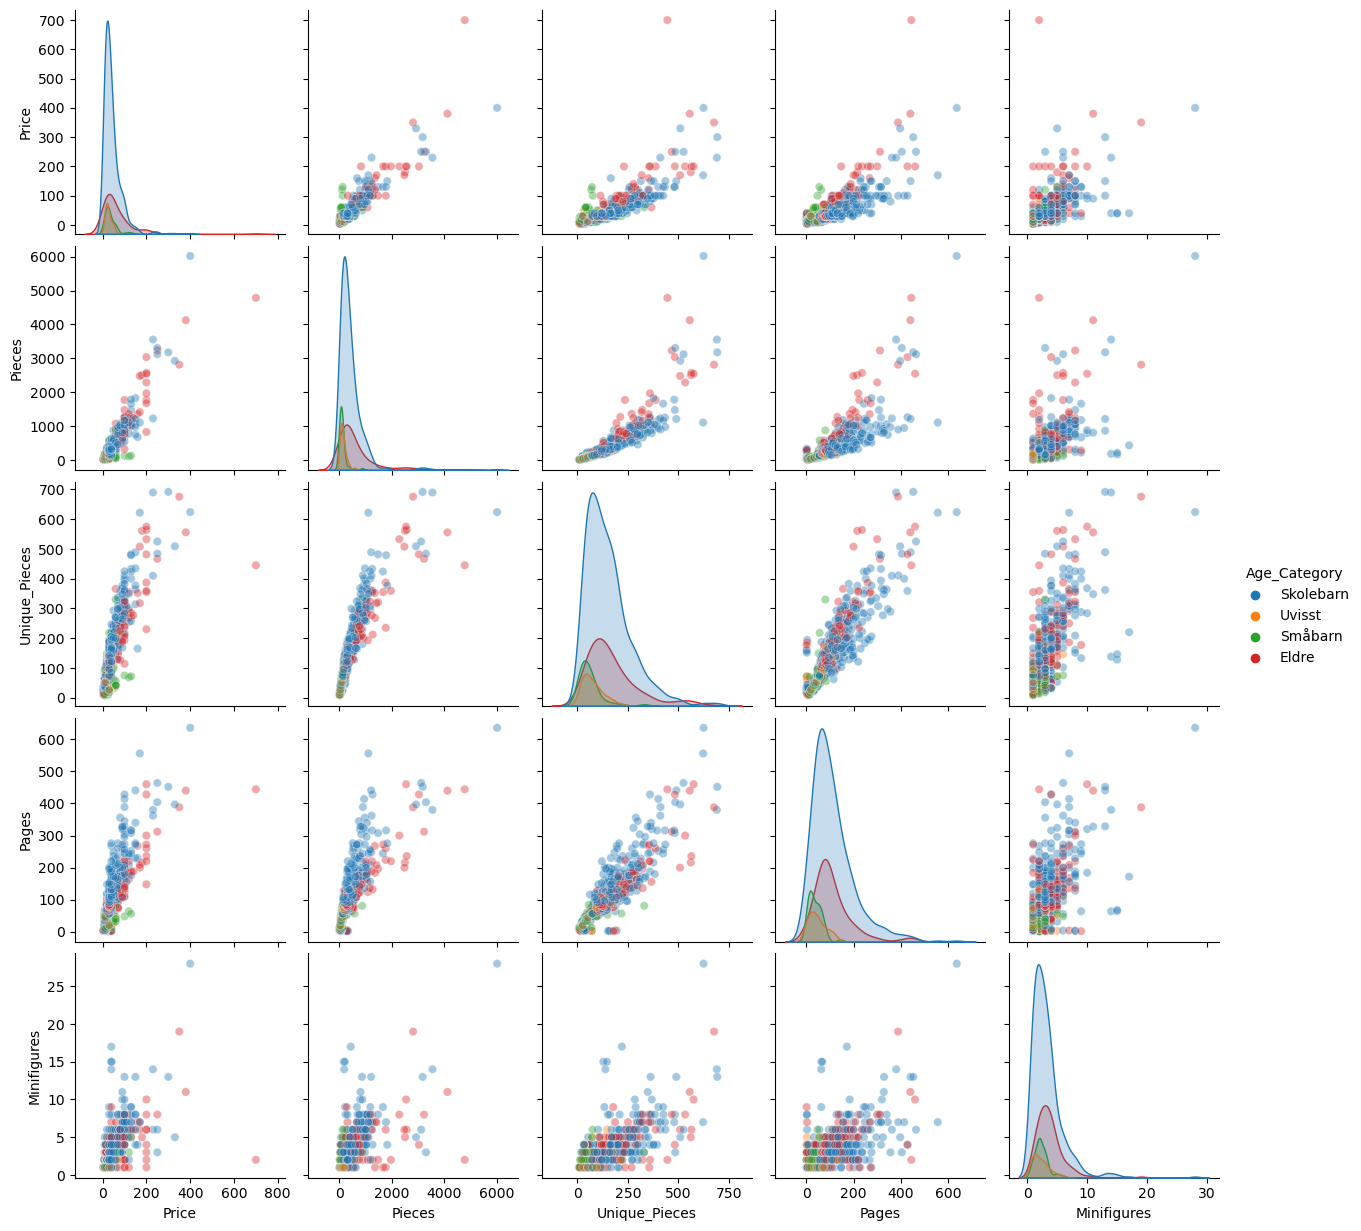

In [623]:
sns.pairplot(df2, vars = ['Price', 'Pieces', 'Unique_Pieces', 'Pages', 'Minifigures'],
             hue = 'Age_Category', 
             diag_kind = 'kde',
             plot_kws = dict(alpha = 0.4))
plt.show()

In [624]:
df4 = df2[['Price', 'Pieces', 'Unique_Pieces', 'Pages', 'Minifigures', 'Age_Category']]

# Remove all rows with Age_Category = 'Uvisst' or 'Unknown'
df4 = df4[df4['Age_Category'] != 'Uvisst']
df4 = df4[df4['Age_Category'] != 'Unknown']
df4 = pd.get_dummies(df4, prefix = 'Age_Category', columns = ['Age_Category'])

# enkel lineær regresjon
formel = 'Price ~ Pieces + Unique_Pieces + Pages + Minifigures + Age_Category_Skolebarn + Age_Category_Småbarn + Age_Category_Eldre'

modell = smf.ols(formel, data = df4)
resultat = modell.fit()

resultat.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     677.4
Date:                Mon, 20 Nov 2023   Prob (F-statistic):          2.37e-280
Time:                        00:29:41   Log-Likelihood:                -3001.7
No. Observations:                 676   AIC:                             6017.
Df Residuals:                     669   BIC:                             6049.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          7.5318      1.231      6.119      0.000       5.115       9.949
Age_Category_Skolebarn[T.True]    -6.5888      1.252     -5.262      0.000      -9.047      -4.130
Age_Category_Småbarn[T.True]      14.7020      2.310      6.365      0.000      10.167      19.237
Age_Category_Eldre[T.True]        -0.5814      1.555     -0.374      0.709      -3.635       2.472
Pieces                             0.0759      0.003     26.151      0.000       0.070       0.082
Unique_Pieces                     -0.0170      0.020     -0.859      0.391      -0.056       0.022
Pages                              0.1111      0.021      5.279      0.000       0.070       0.152
Minifigures                        0.5265      0.435      1.211      0.226      -0.327       1.380
==============================================================================
Omnibus:                      715.600   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           112462.139
Skew:                           4.478   Prob(JB):                         0.00
Kurtosis:                      65.550   Cond. No.                     7.43e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.8e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [625]:
df4 = df2[['Price', 'Pieces', 'Unique_Pieces', 'Pages', 'Minifigures', 'Age_Category']]

# Remove all rows with Age_Category = 'Uvisst' or 'Unknown'
df4 = df4[df4['Age_Category'] != 'Uvisst']
df4 = df4[df4['Age_Category'] != 'Unknown']

# Convert Age_Category to numerical values for regression analysis
df4['Age_Category_Num'] = df4['Age_Category'].map({'Småbarn': 1, 'Skolebarn': 2, 'Eldre': 3})

# Fit the regression model using OLS
X = sm.add_constant(df4[['Age_Category_Num']])
y = df4['Price']
model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     20.33
Date:                Mon, 20 Nov 2023   Prob (F-statistic):           7.70e-06
Time:                        00:29:41   Log-Likelihood:                -3653.0
No. Observations:                 676   AIC:                             7310.
Df Residuals:                     674   BIC:                             7319.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                9.1951      8.733  

In [626]:
df4 = df2[['Price', 'Pieces', 'Unique_Pieces', 'Pages', 'Minifigures', 'Age_Category_Ages']]

# Remove all rows with Age_Category = 'Uvisst' or 'Unknown'
df4 = df4[df4['Age_Category_Ages'] != 'Uvisst']
df4 = df4[df4['Age_Category_Ages'] != 'Unknown']

df4 = pd.get_dummies(df4, prefix = 'Age_Category', columns = ['Age_Category_Ages'])

# enkel lineær regresjon
formel = 'Price ~ Pieces + Unique_Pieces + Pages + Minifigures + Age_Category_Skolebarn + Age_Category_Småbarn + Age_Category_Eldre + Age_Category_Eldre_skolebarn'

modell = smf.ols(formel, data = df4)
resultat = modell.fit()

resultat.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     632.5
Date:                Mon, 20 Nov 2023   Prob (F-statistic):          3.48e-299
Time:                        00:29:41   Log-Likelihood:                -3145.3
No. Observations:                 714   AIC:                             6307.
Df Residuals:                     706   BIC:                             6343.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                5.2124      2.154      2.420      0.016       0.983       9.441
Age_Category_Skolebarn[T.True]          -3.0295      1.917     -1.580      0.114      -6.793       0.734
Age_Category_Småbarn[T.True]            24.8558      3.187      7.798      0.000      18.598      31.114
Age_Category_Eldre[T.True]             -12.7481      5.699     -2.237      0.026     -23.937      -1.559
Age_Category_Eldre_skolebarn[T.True]    -3.8657      2.428     -1.592      0.112      -8.633       0.901
Pieces                                   0.0798      0.004     21.665      0.000       0.073       0.087
Unique_Pieces                           -0.0022      0.020     -0.112      0.911      -0.041       0.036
Pages                                    0.0882      0.020      4.354      0.000       0.048       0.128
Minifigures                              0.3149      0.426      0.740      0.460      -0.521       1.151
==============================================================================
Omnibus:                      770.195   Durbin-Watson:                   1.799
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           141458.416
Skew:                           4.603   Prob(JB):                         0.00
Kurtosis:                      71.339   Cond. No.                     6.47e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.02e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

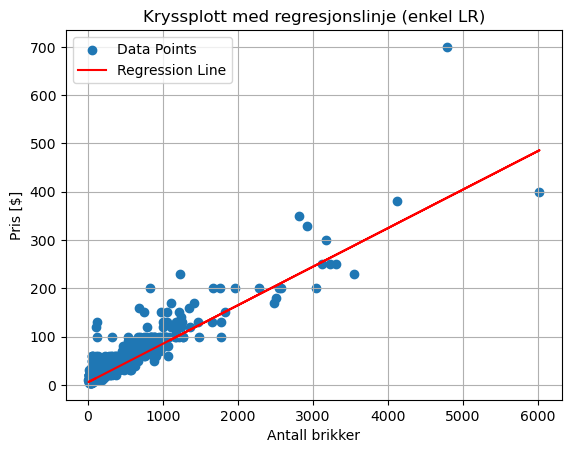

In [627]:
slope = resultat.params['Pieces']
intercept = resultat.params['Intercept']

regression_x = np.array(df2['Pieces'])

regression_y = slope * regression_x + intercept

plt.scatter(df2['Pieces'], df2['Price'], label='Data Points')
plt.plot(regression_x, regression_y, color='red', label='Regression Line')
plt.xlabel('Antall brikker')
plt.ylabel('Pris [$]')
plt.title('Kryssplott med regresjonslinje (enkel LR)')
plt.legend()
plt.grid()
plt.show()

c:\Users\a_lun\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\a_lun\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


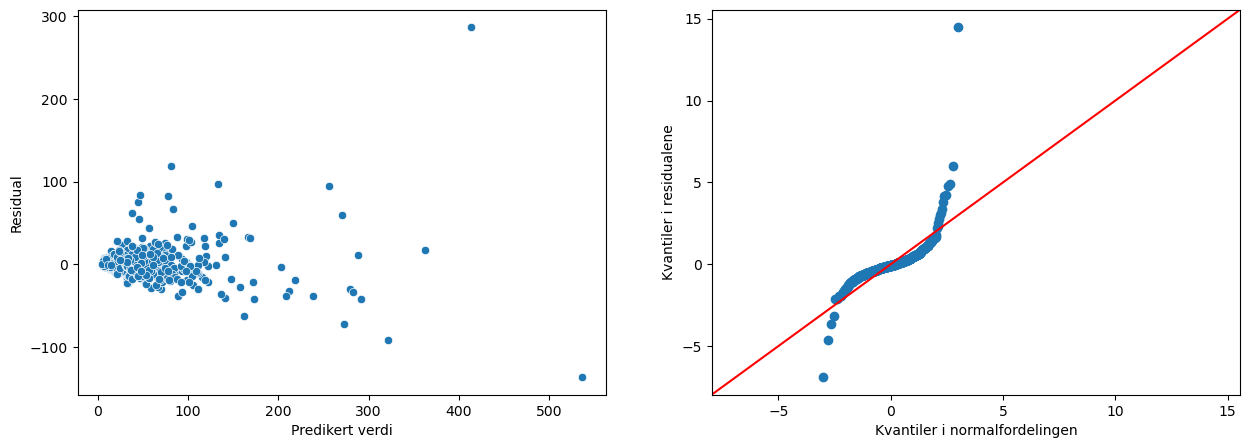

In [628]:
figure, axis = plt.subplots(1, 2, figsize = (15, 5))
sns.scatterplot(x = resultat.fittedvalues, y = resultat.resid, ax = axis[0])
axis[0].set_ylabel("Residual")
axis[0].set_xlabel("Predikert verdi")

sm.qqplot(resultat.resid, line = '45', fit = True, ax = axis[1])
axis[1].set_ylabel("Kvantiler i residualene")
axis[1].set_xlabel("Kvantiler i normalfordelingen")
plt.show()

c:\Users\a_lun\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\a_lun\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\a_lun\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\a_lun\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

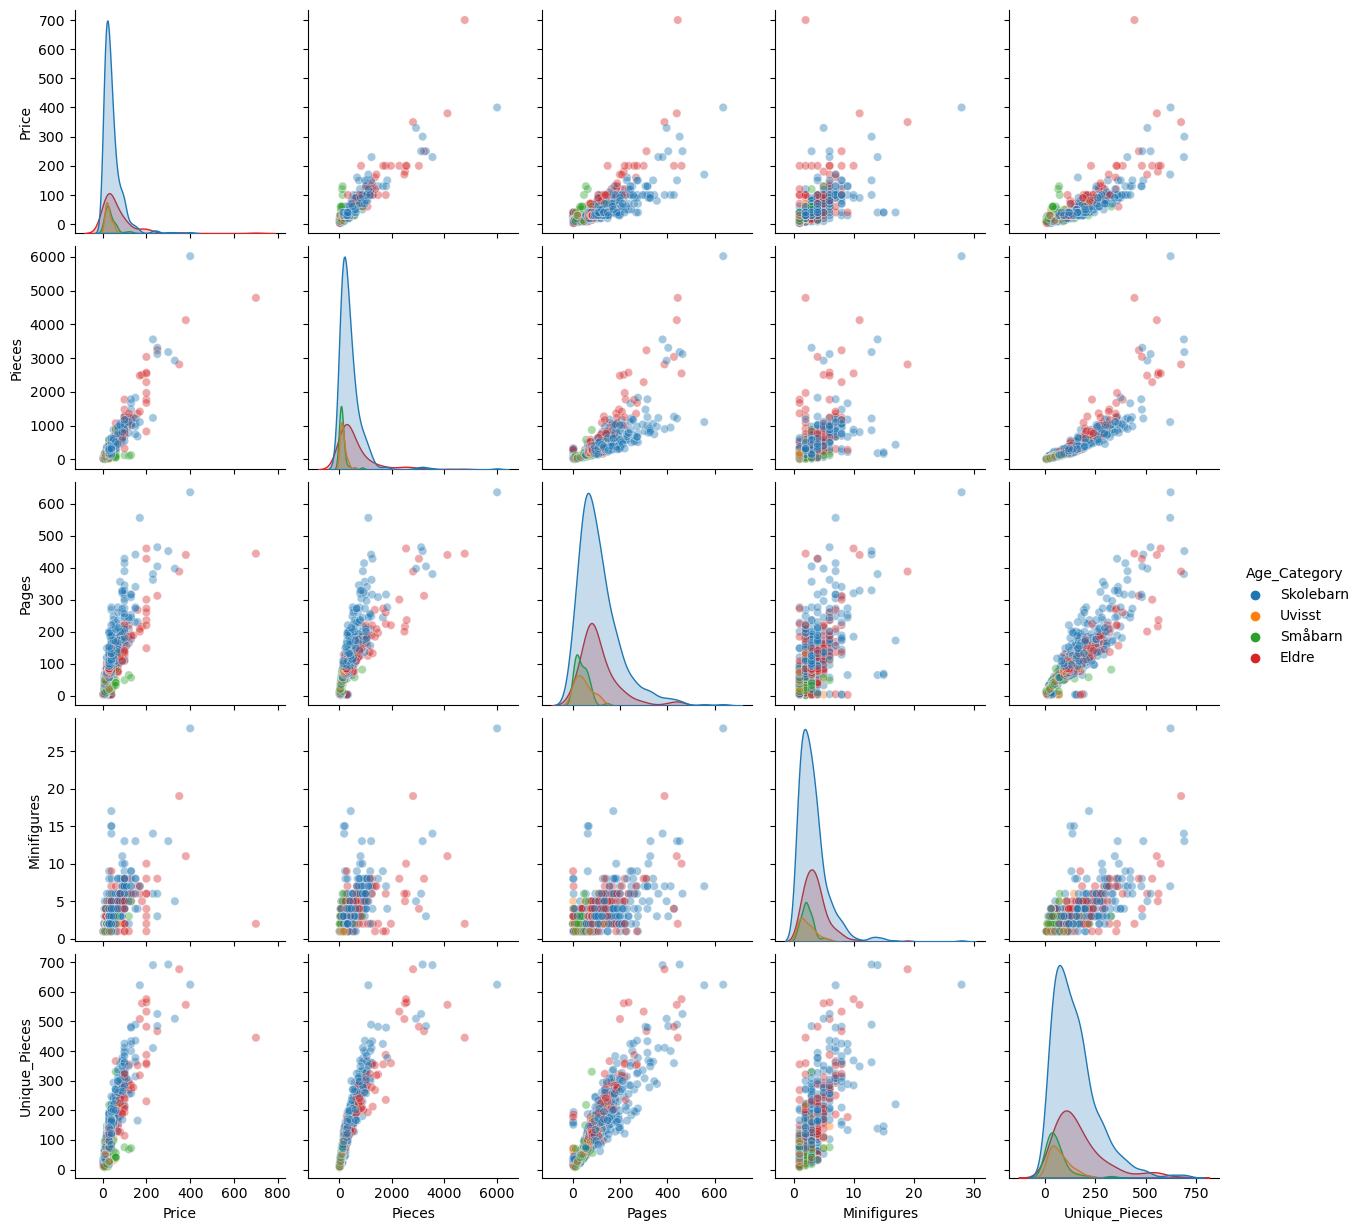

In [629]:
# mythemes = ['Star Wars', 'NINJAGO', 'Harry Potter']
# subset_df = df2[df2['Theme'].isin(mythemes)]
subset_df = df2
sns.pairplot(subset_df, vars = ['Price', 'Pieces', 'Pages', 'Minifigures', 'Unique_Pieces'],
             hue = 'Age_Category', 
             diag_kind = 'kde',
             plot_kws = dict(alpha = 0.4))
plt.show()

In [630]:
# enkel lineær regresjon, tar ikke hensyn til tema
res_sub = smf.ols('Price ~ Pieces' , data = subset_df).fit()

In [631]:
# enkel LR for hvert tema hver for seg
resultater = []
ageCategories = subset_df['Age_Category'].unique()
for i, ageCategory in enumerate(ageCategories):
    modell3 = smf.ols('Price ~ Pieces' , data = subset_df[subset_df['Age_Category'].isin([ageCategory])])
    resultater.append(modell3.fit())

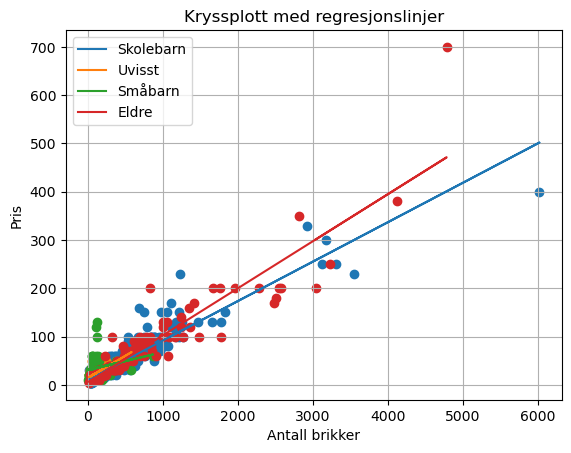

In [632]:
# plott av dataene og regresjonslinjene
for i, ageCategory in enumerate(ageCategories):
    slope = resultater[i].params['Pieces']
    intercept = resultater[i].params['Intercept']

    regression_x = np.array(subset_df[subset_df['Age_Category'].isin([ageCategory])]['Pieces'])
    regression_y = slope * regression_x + intercept

    # Plot scatter plot and regression line
    plt.scatter(subset_df[subset_df['Age_Category'].isin([ageCategory])]['Pieces'], subset_df[subset_df['Age_Category'].isin([ageCategory])]['Price'], color=plt.cm.tab10(i))
    plt.plot(regression_x, regression_y, color=plt.cm.tab10(i), label=ageCategory)
    
plt.xlabel('Antall brikker')
plt.ylabel('Pris')
plt.title('Kryssplott med regresjonslinjer')
plt.legend()
plt.grid()
plt.show()

In [633]:
print(df2['Age_Category'].unique())

['Skolebarn' 'Uvisst' 'Småbarn' 'Eldre']


In [634]:
# Failed attempt at doing MLR

# # Konverter Age_Category til dummy-variabler
# df3 = df2.copy()
# df3['Age_Category'].fillna('missing', inplace=True)
# df3 = pd.get_dummies(df3, columns=['Age_Category'], drop_first=True)

# # Velg forklaringsvariabler og responsvariabel
# X = df3.drop(['Price', 'Set_Name', 'Theme', 'Unique_Pieces', 'Pages', 'Minifigures', 'Ages', 'Pieces'], axis=1)
# y = df3['Price']

# # Print data types of X for verification
# print(X.dtypes)
# print(y.dtypes)
# print(X.value_counts())

# columns_to_fill = ['Age_Category_Older_Children', 'Age_Category_Teenagers_and_Adults', 'Age_Category_Toddler', 'Age_Category_Young_Children']

# # Fill missing values with 0 for the specified columns
# df3[columns_to_fill] = df3[columns_to_fill].fillna(0)

# df3[columns_to_fill] = df3[columns_to_fill].replace('', False)
# df3[columns_to_fill] = df3[columns_to_fill].fillna(False)

# for column in columns_to_fill:
#     df[df[column] != True]
#     if (df3[column].any()):
#         print(column, df3[column].unique())

# # Legg til en konstant til X (nødvendig for statsmodels)
# X = sm.add_constant(X)

# # Opprett og tilpasse modellen
# model = sm.OLS(y, X).fit()

# # Print ut en oppsummering av modellen
# print(model.summary())


In [635]:
# multippel lineær regresjon
modell3_mlr = smf.ols('Price ~ Pieces + Theme' , data = subset_df)
modell3_mlr.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     155.5
Date:                Mon, 20 Nov 2023   Prob (F-statistic):          1.82e-285
Time:                        00:29:46   Log-Likelihood:                -3108.1
No. Observations:                 714   AIC:                             6280.
Df Residuals:                     682   BIC:                             6426.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      4.3689      4.860      0.899      0.369      -5.173      13.911
Theme[T.City]                 12.0619      5.208      2.316      0.021       1.835      22.288
Theme[T.Classic]             -18.2671     10.756     -1.698      0.090     -39.385       2.851
Theme[T.Creator 3-in-1]       -4.4112      6.386     -0.691      0.490     -16.949       8.126
Theme[T.Creator Expert]      -14.8868      8.122     -1.833      0.067     -30.833       1.060
Theme[T.DC]                   12.3014      8.332      1.476      0.140      -4.058      28.661
Theme[T.DUPLO]                30.0527      5.924      5.073      0.000      18.422      41.683
Theme[T.Disney]               10.5582      5.826      1.812      0.070      -0.881      21.997
Theme[T.Friends]               0.6471      5.211      0.124      0.901      -9.584      10.879
Theme[T.Harry Potter]         -6.8735      6.336     -1.085      0.278     -19.315       5.568
Theme[T.Hidden Side]          -2.3090      6.529     -0.354      0.724     -15.128      10.510
Theme[T.Ideas]               -22.8383      8.418     -2.713      0.007     -39.367      -6.310
Theme[T.Juniors]               8.3857      7.364      1.139      0.255      -6.073      22.845
Theme[T.Jurassic World]       11.2029      6.529      1.716      0.087      -1.616      24.022
Theme[T.LEGO Frozen 2]        13.0095      8.722      1.492      0.136      -4.116      30.135
Theme[T.Marvel]                1.2483      5.571      0.224      0.823      -9.690      12.187
Theme[T.Minecraft]            -0.5404      6.387     -0.085      0.933     -13.081      12.000
Theme[T.Minifigures]           4.4391     12.121      0.366      0.714     -19.360      28.239
Theme[T.Minions]             -15.3808     14.430     -1.066      0.287     -43.714      12.953
Theme[T.Monkie Kid]           25.0936      8.019      3.129      0.002       9.348      40.839
Theme[T.NINJAGO]              -5.2578      5.286     -0.995      0.320     -15.638       5.122
Theme[T.Overwatch]             0.5288      8.720      0.061      0.952     -16.593      17.651
Theme[T.Powered UP]           59.7009     20.172      2.960      0.003      20.095      99.307
Theme[T.Powerpuff Girls]       3.7113     14.436      0.257      0.797     -24.634      32.056
Theme[T.Speed Champions]      -7.5620      6.704     -1.128      0.260     -20.726       5.602
Theme[T.Spider-Man]            9.3468     14.431      0.648      0.517     -18.987      37.681
Theme[T.Star Wars]            11.0747      5.244      2.112      0.035       0.779      21.371
Theme[T.Stranger Things]     -12.2967     20.019     -0.614      0.539     -51.604      27.010
Theme[T.THE LEGO MOVIE 2]      2.1463      6.161      0.348      0.728      -9.951      14.243
Theme[T.Trolls World Tour]     3.4270      

In [636]:
# multippel lineær regresjon med en annen referansekategori
modell3_mlr_alt = smf.ols('Price ~ Pieces + C(Age_Category, Treatment("Skolebarn"))' , data = subset_df)
modell3_mlr_alt.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     1001.
Date:                Mon, 20 Nov 2023   Prob (F-statistic):          8.16e-290
Time:                        00:29:46   Log-Likelihood:                -3177.5
No. Observations:                 714   AIC:                             6365.
Df Residuals:                     709   BIC:                             6388.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                              7.5181      1.118      6.723      0.000       5.323       9.713
C(Age_Category, Treatment("Skolebarn"))[T.Eldre]       3.1358      1.932      1.623      0.105      -0.657       6.929
C(Age_Category, Treatment("Skolebarn"))[T.Småbarn]    17.7321      3.179      5.577      0.000      11.490      23.974
C(Age_Category, Treatment("Skolebarn"))[T.Uvisst]      7.2710      3.528      2.061      0.040       0.345      14.197
Pieces                                                 0.0884      0.001     61.796      0.000       0.086       0.091
==============================================================================
Omnibus:                      638.015   Durbin-Watson:                   1.823
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            63155.522
Skew:                           3.486   Prob(JB):                         0.00
Kurtosis:                      48.544   Cond. No.                     3.25e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.25e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

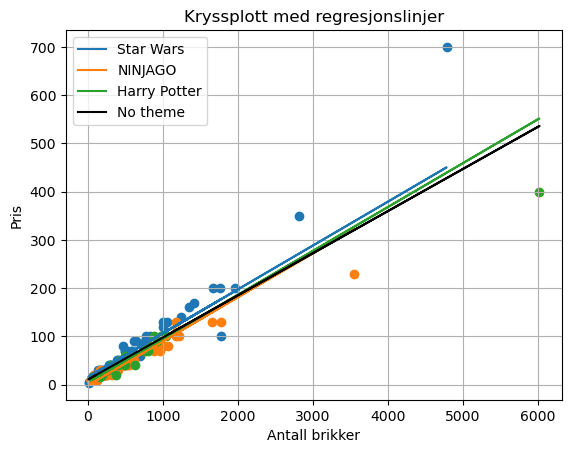

In [637]:
# plott
intercept = [modell3_mlr.fit().params['Theme[T.Star Wars]'], modell3_mlr.fit().params['Theme[T.NINJAGO]'], 0] + modell3_mlr.fit().params['Intercept']
slope = modell3_mlr.fit().params['Pieces']

for i, theme in enumerate(mythemes):

    regression_x = np.array(subset_df[subset_df['Theme'].isin([theme])]['Pieces'])
    regression_y = slope * regression_x + intercept[i]

    # Plot scatter plot and regression line
    plt.scatter(subset_df[subset_df['Theme'].isin([theme])]['Pieces'], subset_df[subset_df['Theme'].isin([theme])]['Price'], color = plt.cm.tab10(i))
    plt.plot(regression_x, regression_y, color=plt.cm.tab10(i), label=theme)
    
# uten tema som forklaringsvariabel:
regression_x = np.array(subset_df['Pieces'])
regression_y = res_sub.params['Pieces'] * regression_x + res_sub.params['Intercept']
plt.plot(regression_x, regression_y, color='black', label = 'No theme')
    
plt.xlabel('Antall brikker')
plt.ylabel('Pris')
plt.title('Kryssplott med regresjonslinjer')
plt.legend()
plt.grid()
plt.show()

In [638]:
# med interaksjonsledd mellom antall brikker og tema
modell3_mlri = smf.ols('Price ~ Pieces*Theme' , data = subset_df)
modell3_mlri.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     180.3
Date:                Mon, 20 Nov 2023   Prob (F-statistic):               0.00
Time:                        00:29:47   Log-Likelihood:                -2836.5
No. Observations:                 714   AIC:                             5793.
Df Residuals:                     654   BIC:                             6067.
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            12.8240      3.920      3.272      0.001       5.128      20.521
Theme[T.City]                       -10.8225      4.419     -2.449      0.015     -19.500      -2.145
Theme[T.Classic]                    -15.9929     14.453     -1.107      0.269     -44.373      12.387
Theme[T.Creator 3-in-1]              -6.8392      7.725     -0.885      0.376     -22.009       8.330
Theme[T.Creator Expert]              19.8369     10.360      1.915      0.056      -0.507      40.180
Theme[T.DC]                          -5.2547     11.725     -0.448      0.654     -28.277      17.768
Theme[T.DUPLO]                       -8.0787      5.631     -1.435      0.152     -19.135       2.978
Theme[T.Disney]                       2.4901      5.305      0.469      0.639      -7.928      12.908
Theme[T.Friends]                     -9.5428      4.436     -2.151      0.032     -18.253      -0.833
Theme[T.Harry Potter]                 3.9885      5.183      0.770      0.442      -6.188      14.165
Theme[T.Hidden Side]                 -8.9729      6.851     -1.310      0.191     -22.425       4.479
Theme[T.Ideas]                        2.2322      9.012      0.248      0.804     -15.464      19.928
Theme[T.Juniors]                     -3.9385      8.585     -0.459      0.647     -20.797      12.920
Theme[T.Jurassic World]               9.4258      5.525      1.706      0.088      -1.422      20.274
Theme[T.LEGO Frozen 2]               -1.0400      9.906     -0.105      0.916     -20.492      18.412
Theme[T.Marvel]                      -7.9093      4.985     -1.587      0.113     -17.698       1.879
Theme[T.Minecraft]                  -12.9761      7.155     -1.814      0.070     -27.026       1.074
Theme[T.Minifigures]                  0.1660     95.739      0.002      0.999    -187.827     188.159
Theme[T.Minions]                      1.6525     16.562      0.100      0.921     -30.869      34.174
Theme[T.Monkie Kid]                  -9.2557      9.389     -0.986      0.325     -27.691       9.180
Theme[T.NINJAGO]                     -4.9005      4.388     -1.117      0.265     -13.518       3.717
Theme[T.Overwatch]                  -18.6960     11.702     -1.598      0.111     -41.675       4.283
Theme[T.Powered UP]                1.222e-05   2.05e-06      5.970      0.000     8.2e-06    1.62e-05
Theme[T.Powerpuff Girls]             -9.9769     43.301     -0.230      0.818     -95.002      75.048
Theme[T.Speed Champions]            -19.0778      7.633     -2.499      0.013     -34.065      -4.090
Theme[T.Spider-Man]                 -38.8340     37.528     -1.035      0.301    -112.523      34.855
Theme[T.Star Wars]                  -16.6079      4.324     -3.841      0.000     -25.099      -8.117
Theme[T.Stranger Things

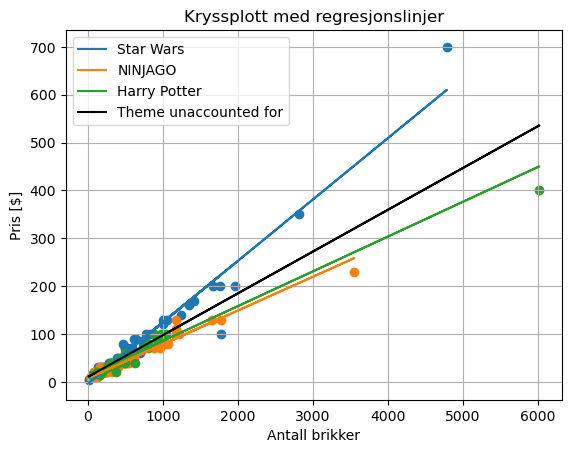

In [639]:
# plott
intercept = [modell3_mlri.fit().params['Theme[T.Star Wars]'], modell3_mlri.fit().params['Theme[T.NINJAGO]'], 0] + modell3_mlri.fit().params['Intercept']
slope = [modell3_mlri.fit().params['Pieces:Theme[T.Star Wars]'], modell3_mlri.fit().params['Pieces:Theme[T.NINJAGO]'], 0] + modell3_mlri.fit().params['Pieces']

for i, theme in enumerate(mythemes):

    regression_x = np.array(subset_df[subset_df['Theme'].isin([theme])]['Pieces'])
    regression_y = slope[i] * regression_x + intercept[i]

    # Plot scatter plot and regression line
    plt.scatter(subset_df[subset_df['Theme'].isin([theme])]['Pieces'], subset_df[subset_df['Theme'].isin([theme])]['Price'], color=plt.cm.tab10(i))
    plt.plot(regression_x, regression_y, color=plt.cm.tab10(i), label=theme)
    
# uten tema som forklaringsvariabel:
regression_x = np.array(subset_df['Pieces'])
regression_y = res_sub.params['Pieces'] * regression_x + res_sub.params['Intercept']
plt.plot(regression_x, regression_y, color='black', label='Theme unaccounted for')
    
plt.xlabel('Antall brikker')
plt.ylabel('Pris [$]')
plt.title('Kryssplott med regresjonslinjer')
plt.legend()
plt.grid()
plt.show()

In [640]:
# Kode for å lagre plot som (.png)
## fjern 'plt.show()' og erstatt med:
# plt.savefig('my_plot.png')

c:\Users\a_lun\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\a_lun\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


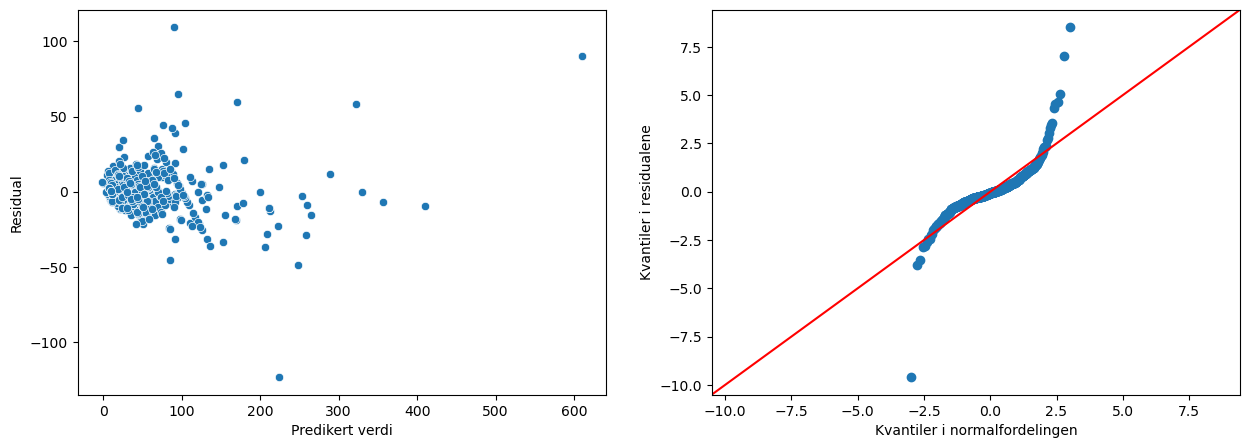

In [641]:
# Steg 5: Evaluere om modellen passer til dataene
# Plotte predikert verdi mot residual
figure, axis = plt.subplots(1, 2, figsize = (15, 5))
sns.scatterplot(x = modell3_mlri.fit().fittedvalues, y = modell3_mlri.fit().resid, ax = axis[0])
axis[0].set_ylabel("Residual")
axis[0].set_xlabel("Predikert verdi")

# Lage kvantil-kvantil-plott for residualene
sm.qqplot(modell3_mlri.fit().resid, line = '45', fit = True, ax = axis[1])
axis[1].set_ylabel("Kvantiler i residualene")
axis[1].set_xlabel("Kvantiler i normalfordelingen")
plt.show()

In [642]:
# Gruppere temaer i nye grupper:
# (Harry Potter, NINJAGO og Star Wars havner i én gruppe, City og Friends i en annen, og alle andre i en tredje)
df2['cat'] = np.where(df2['Theme'].isin(['Harry Potter', 'NINJAGO', 'Star Wars']), 'Cat1', 
                      np.where(df2['Theme'].isin(['City', 'Friends']), 'Cat2', 'Cat3'))
df2.groupby(['cat']).size().reset_index(name = 'Count')

,cat,Count
0,Cat1,184
1,Cat2,188
2,Cat3,342


In [643]:
df2.groupby(['cat', 'Theme']).size().reset_index(name = 'Count')


,cat,Theme,Count
0,Cat1,Harry Potter,22
1,Cat1,NINJAGO,77
2,Cat1,Star Wars,85
3,Cat2,City,94
4,Cat2,Friends,94
5,Cat3,Batman,16
6,Cat3,Classic,4
7,Cat3,Creator 3-in-1,21
8,Cat3,Creator Expert,10
9,Cat3,DC,8


In [644]:
df5 = df2.copy()

# Converting the Price column to numeric, removing any non-numeric characters
df5['Price'] = pd.to_numeric(df5['Price'].replace('[\$,]', '', regex=True), errors='coerce')

# Defining the age categories based on themes
age_categories = {
    'Skolebarn': ['Friends', 'City', 'Unikitty', 'NINJAGO', 'Minecraft', 'Batman',
                  'THE LEGO MOVIE 2', 'Speed Champions', 'Harry Potter', 'Hidden Side',
                  'LEGO Frozen 2', 'Trolls World Tour', 'Minions', 'Powerpuff Girls',
                  'Jurassic World', 'Overwatch', 'Spider-Man', 'Creator 3-in-1', 'Monkie Kid',
                  'Powered UP'],
    'Uvisst': ['Disney', 'Minifigures'],
    'Småbarn': ['DUPLO', 'Classic', 'Juniors'],
    'Eldre': ['Star Wars', 'Marvel', 'DC', 'Ideas', 'Creator Expert', 'Stranger Things']
}

# Assigning age categories to the LEGO sets in the dataset
df5['Age_Category'] = df5['Theme'].apply(lambda theme: next((category for category, themes in age_categories.items() if theme in themes), 'Unknown'))

# Preparing dataset for regression analysis, including age categories
regression_dataset_with_age = df5[['Price', 'Pages', 'Pieces', 'Unique_Pieces', 'Minifigures', 'Age_Category']].dropna()

# One-hot encoding for age categories
regression_dataset_with_age = pd.get_dummies(regression_dataset_with_age, columns=['Age_Category'], drop_first=True)

# Defining the dependent variable (y) and independent variables (X) including age categories
y_with_age = regression_dataset_with_age['Price']
X_with_age = regression_dataset_with_age.drop('Price', axis=1)

# Creating the Linear Regression model
model_with_age = LinearRegression()

# Fitting the model with the dataset
model_with_age.fit(X_with_age, y_with_age)

# Getting the coefficients and intercept of the model
coefficients_with_age = model_with_age.coef_
intercept_with_age = model_with_age.intercept_

# Creating a dictionary to map the coefficients to their corresponding variables
variable_names = X_with_age.columns.tolist()
coefficients_dict = dict(zip(variable_names, coefficients_with_age))

# Adding the intercept to the dictionary
coefficients_dict['Intercept'] = intercept_with_age

# Displaying the detailed results
coefficients_dict


NameError: name 'lego_population' is not defined